<a href="https://colab.research.google.com/github/LAMECH9/TakaTech_AI/blob/main/TAKATECH_AI_OpenEPI_HACKATHON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methane Gas Mitigation from Market Food Waste Using Deep Learning

This project aims to develop a deep learning system to optimize food waste management in markets to reduce methane emissions

# Step 1: Setup Environment and Install Dependencies

This line of code uses the pip package manager to install several essential Python libraries needed for data analysis, visualization, machine learning, and deep learning: pandas for data manipulation, numpy for numerical operations, matplotlib and seaborn for data visualization, scikit-learn for machine learning algorithms, tensorflow and keras for deep learning model development, opencv-python for computer vision tasks, and pywt for wavelet transformations (often used in signal processing). These dependencies collectively provide the foundation for the subsequent steps in the methane gas mitigation project, enabling data processing, model building, and analysis.

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras opencv-python pywt

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


# Step 2: Generate Synthetic Dataset

This code generates a synthetic dataset simulating food waste management scenarios by creating 10,000 sample entries with features like waste amount, type, temperature, humidity, storage duration, and treatment method, then calculates methane emissions based on weighted factors for each feature (with different waste types and treatments having varying impacts) while adding random noise for realism. It also determines optimal mitigation strategies (like anaerobic capture or composting) based on emission thresholds, assigns random dates within a year, and structures the data into a pandas DataFrame with columns for each feature before saving it to a CSV file. The random seeds (42) ensure reproducibility, and the final output shows the first few rows of the generated dataset for verification. This synthetic data is designed to mimic real-world conditions for training machine learning models on methane mitigation strategies.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate synthetic dataset
def generate_food_waste_data(num_samples=10000):
    data = []

    for _ in range(num_samples):
        # Basic features
        waste_amount = np.random.uniform(0.5, 100)  # kg
        waste_type = random.choice(['vegetable', 'fruit', 'meat', 'dairy', 'mixed'])
        temperature = np.random.uniform(5, 35)  # °C
        humidity = np.random.uniform(30, 95)  # %
        storage_days = np.random.randint(1, 14)
        treatment = random.choice(['composting', 'anaerobic', 'landfill', 'incineration'])

        # Calculate methane potential based on features
        if waste_type == 'vegetable':
            methane_factor = 0.05
        elif waste_type == 'fruit':
            methane_factor = 0.06
        elif waste_type == 'meat':
            methane_factor = 0.12
        elif waste_type == 'dairy':
            methane_factor = 0.10
        else:
            methane_factor = 0.08

        if treatment == 'composting':
            methane_factor *= 0.2
        elif treatment == 'anaerobic':
            methane_factor *= 1.2
        elif treatment == 'landfill':
            methane_factor *= 1.5
        else:
            methane_factor *= 0.05

        # Temperature and humidity effects
        temp_effect = 1 + (temperature - 20) * 0.02
        humidity_effect = 1 + (humidity - 60) * 0.01

        # Time effect
        time_effect = 1 + (storage_days - 1) * 0.1

        # Calculate methane emission
        methane_emission = waste_amount * methane_factor * temp_effect * humidity_effect * time_effect

        # Add some noise
        methane_emission *= np.random.uniform(0.9, 1.1)

        # Optimal mitigation strategy (our target)
        if methane_emission > 5:
            mitigation = 'anaerobic_with_capture'
        elif methane_emission > 2:
            mitigation = 'composting_with_aeration'
        else:
            mitigation = 'direct_animal_feed'

        # Add date
        date = datetime.now() - timedelta(days=random.randint(0, 365))

        data.append([
            date.strftime('%Y-%m-%d'),
            waste_amount,
            waste_type,
            temperature,
            humidity,
            storage_days,
            treatment,
            methane_emission,
            mitigation
        ])

    columns = [
        'date',
        'waste_amount_kg',
        'waste_type',
        'temperature_c',
        'humidity_pct',
        'storage_days',
        'current_treatment',
        'methane_emission_kg',
        'optimal_mitigation'
    ]

    return pd.DataFrame(data, columns=columns)

# Generate dataset
df = generate_food_waste_data(10000)

# Save to CSV
df.to_csv('food_waste_methane_dataset.csv', index=False)
print("Dataset generated and saved successfully!")
print(df.head())

Dataset generated and saved successfully!
         date  waste_amount_kg waste_type  temperature_c  humidity_pct  \
0  2024-12-13        37.766742  vegetable      33.521429     77.579606   
1  2025-02-20        44.860359      fruit       7.999247     59.851178   
2  2024-07-04        70.953221  vegetable       5.617535     93.044140   
3  2025-04-17         0.577487      dairy      34.766347     70.136298   
4  2025-01-03        43.478529  vegetable      13.736874     69.770438   

   storage_days current_treatment  methane_emission_kg  \
0            13        composting             1.265163   
1             5         anaerobic             3.500875   
2            12        composting             1.536011   
3            10        composting             0.031462   
4            10         anaerobic             4.327787   

         optimal_mitigation  
0        direct_animal_feed  
1  composting_with_aeration  
2        direct_animal_feed  
3        direct_animal_feed  
4  composting_

# Step 3: Data Preprocessing and Visualization

This code performs data preprocessing and visualization for the food waste methane dataset: it loads the CSV data, converts dates into numerical features (day of week and month), encodes categorical variables (waste type, treatment, and mitigation strategy) using label encoding, and creates four visualizations (box plots and scatter plots) to analyze relationships between methane emissions and other features. The data is then split into training (80%) and testing (20%) sets, with numerical features standardized using StandardScaler to ensure consistent scales for machine learning. The processed data (features in X, target in y) and scaler are prepared for model training, with categorical encoders preserved for future inverse transformations. The visualizations help identify patterns like higher emissions from certain waste types or treatments, while the preprocessing ensures the data is properly formatted for predictive modeling.

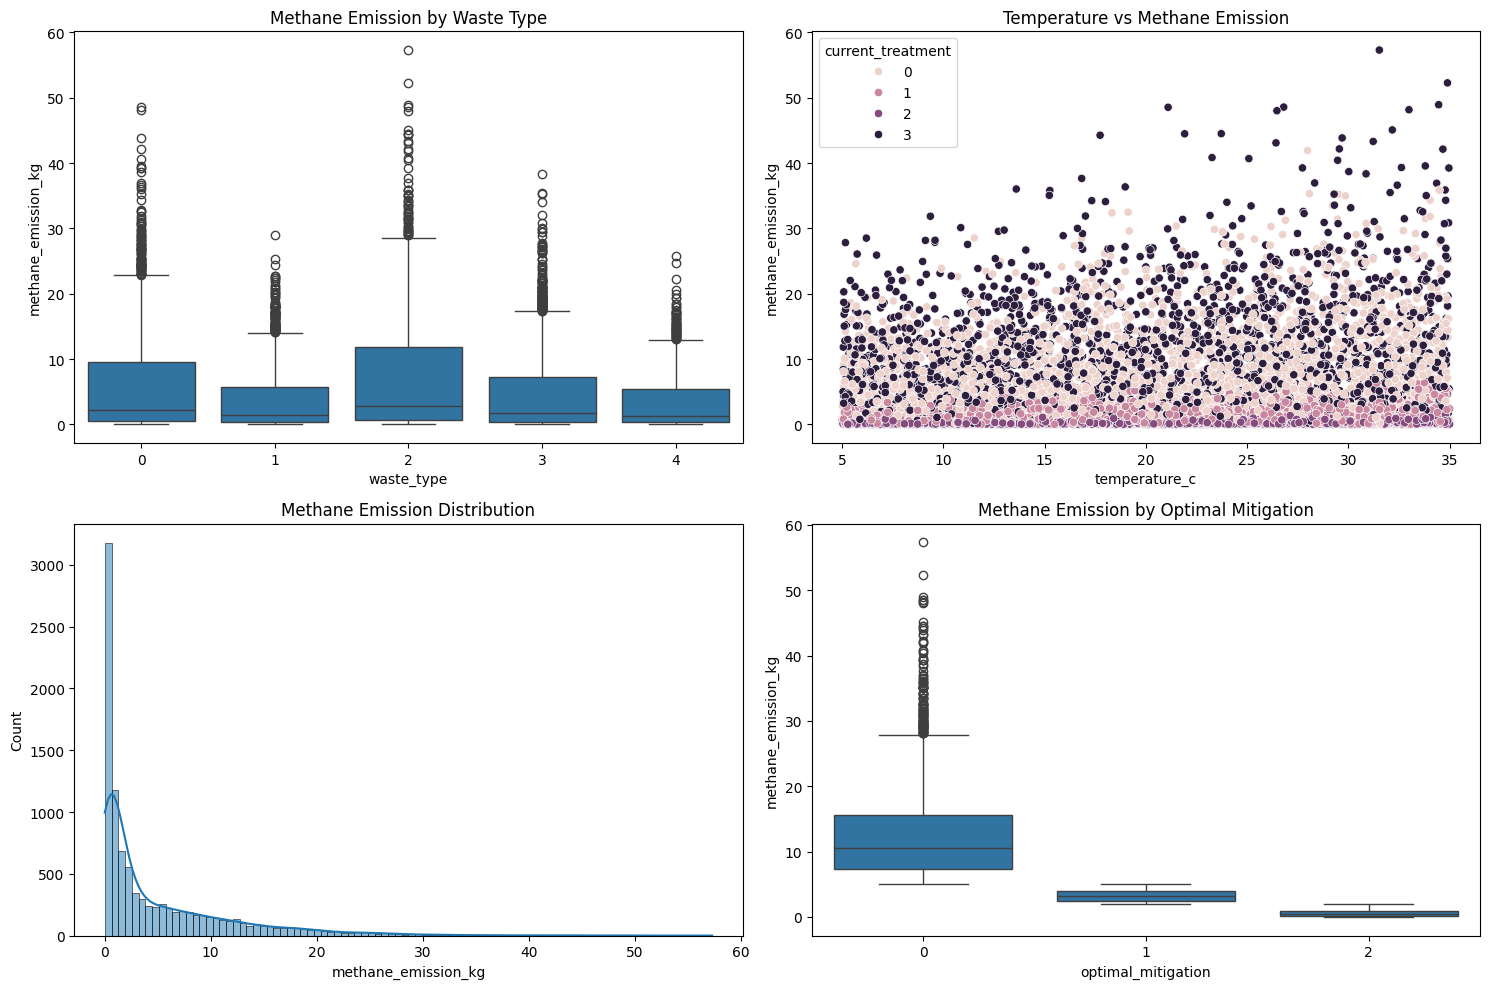

Data preprocessing completed!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('food_waste_methane_dataset.csv')

# Convert date to datetime and extract features
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df = df.drop('date', axis=1)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['waste_type', 'current_treatment', 'optimal_mitigation']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='waste_type', y='methane_emission_kg', data=df)
plt.title('Methane Emission by Waste Type')

plt.subplot(2, 2, 2)
sns.scatterplot(x='temperature_c', y='methane_emission_kg', hue='current_treatment', data=df)
plt.title('Temperature vs Methane Emission')

plt.subplot(2, 2, 3)
sns.histplot(df['methane_emission_kg'], kde=True)
plt.title('Methane Emission Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x='optimal_mitigation', y='methane_emission_kg', data=df)
plt.title('Methane Emission by Optimal Mitigation')

plt.tight_layout()
plt.show()

# Prepare features and target
X = df.drop(['optimal_mitigation', 'methane_emission_kg'], axis=1)
y = df['optimal_mitigation']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['waste_amount_kg', 'temperature_c', 'humidity_pct', 'storage_days', 'day_of_week', 'month']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Data preprocessing completed!")

# Step 4: Build Deep Learning Model

This code builds, trains, and evaluates a deep neural network (DNN) for classifying optimal methane mitigation strategies using TensorFlow/Keras. It creates a sequential model with three hidden layers (128-256-128 neurons) featuring ReLU activation, batch normalization, and dropout (30%) for regularization, followed by a softmax output layer matching the number of mitigation classes. The model is compiled with the Adam optimizer (learning rate 0.001) and sparse categorical crossentropy loss, then trained for up to 100 epochs with early stopping (patience 10) and learning rate reduction (factor 0.2, patience 5) callbacks to prevent overfitting. Training progress is visualized through accuracy/loss curves for both training and validation sets, and final performance is assessed via a classification report (precision, recall, F1-score) and confusion matrix, showing how well the model predicts different mitigation strategies based on the input features. The architecture balances complexity with regularization techniques to optimize generalization on the food waste methane dataset.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5528 - loss: 1.0994 - val_accuracy: 0.7760 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8005 - loss: 0.5023 - val_accuracy: 0.8885 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8191 - loss: 0.4409 - val_accuracy: 0.9170 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8311 - loss: 0.4017 - val_accuracy: 0.9135 - val_loss: 0.2128 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8488 - loss: 0.3606 - val_accuracy: 0.9080 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8668 - loss: 0.3240 - val_accuracy: 0.9205 - val_loss: 0.1974 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8615 - loss: 0

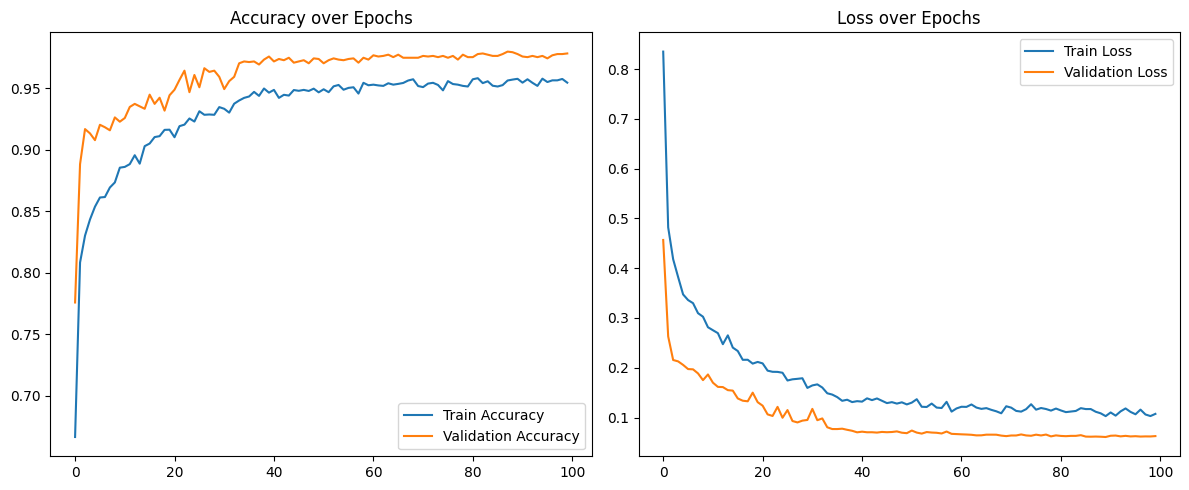

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
                          precision    recall  f1-score   support

  anaerobic_with_capture       0.98      0.98      0.98       640
composting_with_aeration       0.93      0.92      0.93       311
      direct_animal_feed       0.99      0.99      0.99      1049

                accuracy                           0.98      2000
               macro avg       0.97      0.97      0.97      2000
            weighted avg       0.98      0.98      0.98      2000


Confusion Matrix:
[[ 629   11    0]
 [  12  287   12]
 [   0    9 1040]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Define model
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Get number of classes
num_classes = len(label_encoders['optimal_mitigation'].classes_)
input_shape = X_train.shape[1]

# Create model
model = create_model(input_shape, num_classes)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoders['optimal_mitigation'].classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Step 5: Methane Emission Prediction Model

This code implements a deep learning regression model to predict methane emissions from food waste by first preparing the data (splitting into features `X_reg` and target `y_reg` and standardizing numerical features) before constructing a neural network with three hidden layers (128-256-128 neurons) using ReLU activation, batch normalization, and dropout for regularization, and a linear output layer for continuous value prediction. The model is trained using mean squared error loss and the Adam optimizer, with early stopping and learning rate reduction callbacks to optimize performance, while tracking mean absolute error (MAE) as a metric. Training progress is visualized through MAE and loss curves, and the model's predictive performance is quantitatively evaluated using MAE, MSE, RMSE, and R² scores to assess its accuracy in estimating methane emission quantities based on the input features, providing insights into how well it generalizes to unseen data.

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 50.8922 - mae: 5.0518 - val_loss: 17.9246 - val_mae: 2.4277 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.4813 - mae: 2.7896 - val_loss: 7.0591 - val_mae: 1.6724 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.9545 - mae: 2.3814 - val_loss: 5.3652 - val_mae: 1.3615 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.6839 - mae: 2.2792 - val_loss: 5.0916 - val_mae: 1.3701 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.4213 - mae: 2.2815 - val_loss: 4.8460 - val_mae: 1.2887 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10.8431 - mae: 2.1900 - val_loss: 5.0135 - val_mae: 1.2518 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8532 - mae: 2.0852 - val_loss: 4.4390 - val_mae: 1.1907 - learning_rate: 0.0010
Epoc

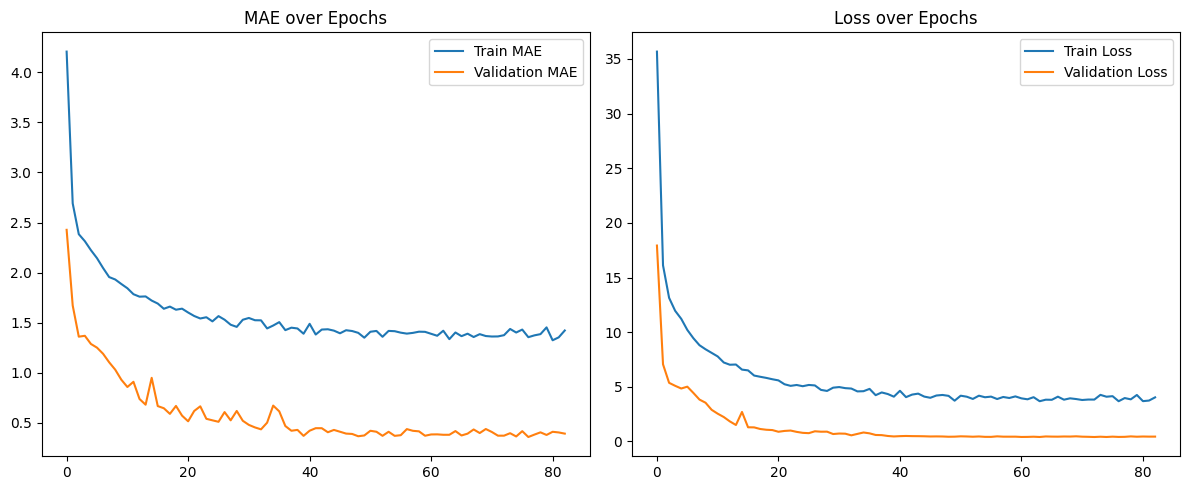

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Regression Metrics:
MAE: 0.3735
MSE: 0.4078
RMSE: 0.6386
R2 Score: 0.9905


In [ ]:
# Prepare data for regression (predicting methane emission)
X_reg = df.drop(['optimal_mitigation', 'methane_emission_kg'], axis=1)
y_reg = df['methane_emission_kg']

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

# Scale numerical features for regression
scaler_reg = StandardScaler()
X_train_reg[num_cols] = scaler_reg.fit_transform(X_train_reg[num_cols])
X_test_reg[num_cols] = scaler_reg.transform(X_test_reg[num_cols])

# Build regression model
def create_regression_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])

    return model

# Create and train regression model
reg_model = create_regression_model(input_shape)

history_reg = reg_model.fit(
    X_train_reg, y_train_reg,
    validation_data=(X_test_reg, y_test_reg),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training history for regression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_reg.history['mae'], label='Train MAE')
plt.plot(history_reg.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate regression model
y_pred_reg = reg_model.predict(X_test_reg)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.4f}")
print(f"R2 Score: {r2_score(y_test_reg, y_pred_reg):.4f}")

# Step 6: Create a Combined Prediction System

This code defines a prediction function `predict_optimal_mitigation` that takes input parameters related to food waste (amount, type, environmental conditions, etc.), preprocesses them by converting the date into numerical features (day of week and month), encoding categorical variables, and scaling numerical values using previously fitted encoders and scalers, then uses the trained regression model (`reg_model`) to predict methane emissions and the classification model (`model`) to recommend the optimal mitigation strategy, returning a dictionary with the predicted methane emission quantity, the recommended mitigation approach, and the probability distribution across all possible mitigation strategies, as demonstrated by the example usage that predicts results for 50kg of mixed waste under specified conditions and prints the formatted output including emission estimates and mitigation recommendations.

In [ ]:
def predict_optimal_mitigation(waste_amount, waste_type, temperature, humidity,
                             storage_days, current_treatment, date):
    # Create input dataframe
    input_data = pd.DataFrame({
        'date': [date],
        'waste_amount_kg': [waste_amount],
        'waste_type': [waste_type],
        'temperature_c': [temperature],
        'humidity_pct': [humidity],
        'storage_days': [storage_days],
        'current_treatment': [current_treatment]
    })

    # Preprocess input data
    input_data['date'] = pd.to_datetime(input_data['date'])
    input_data['day_of_week'] = input_data['date'].dt.dayofweek
    input_data['month'] = input_data['date'].dt.month
    input_data = input_data.drop('date', axis=1)

    # Encode categorical variables
    for col in ['waste_type', 'current_treatment']:
        input_data[col] = label_encoders[col].transform(input_data[col])

    # Scale numerical features
    input_data[num_cols] = scaler.transform(input_data[num_cols])

    # Predict methane emission
    methane_pred = reg_model.predict(input_data)[0][0]

    # Predict optimal mitigation
    mitigation_pred = model.predict(input_data)
    mitigation_class = np.argmax(mitigation_pred, axis=1)[0]
    mitigation_str = label_encoders['optimal_mitigation'].inverse_transform([mitigation_class])[0]

    return {
        'predicted_methane_kg': float(methane_pred),
        'recommended_mitigation': mitigation_str,
        'mitigation_probabilities': {k: float(v) for k, v in zip(
            label_encoders['optimal_mitigation'].classes_,
            mitigation_pred[0]
        )}
    }

# Example usage
example_input = {
    'waste_amount': 50,  # kg
    'waste_type': 'mixed',
    'temperature': 25,  # °C
    'humidity': 70,  # %
    'storage_days': 5,
    'current_treatment': 'landfill',
    'date': '2023-06-15'
}

result = predict_optimal_mitigation(**example_input)
print("\nPrediction Results:")
for k, v in result.items():
    print(f"{k}: {v}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

Prediction Results:
predicted_methane_kg: 9.540704727172852
recommended_mitigation: anaerobic_with_capture
mitigation_probabilities: {'anaerobic_with_capture': 0.9993494153022766, 'composting_with_aeration': 0.0006403009174391627, 'direct_animal_feed': 1.0245298653899226e-05}


# Step 7: Save Models for Deployment

This code handles model persistence by saving both the trained deep learning models (the classification model that predicts optimal mitigation strategies and the regression model that estimates methane emissions) in HDF5 format using Keras's native save functionality, while simultaneously storing the critical preprocessing components (feature scalers for normalization and label encoders for categorical variables) as serialized pickle files using joblib, creating a complete snapshot of the trained system that includes both the predictive models and their associated data transformation pipelines, which enables easy deployment and future reuse without the need to retrain the models or reconfigure the preprocessing steps, with a final status message verifying that all model artifacts and preprocessing objects have been successfully saved to disk for later retrieval and application.

In [ ]:
import joblib

# Save models and preprocessing objects
model.save('methane_mitigation_model.h5')
reg_model.save('methane_emission_model.h5')

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(scaler_reg, 'scaler_reg.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("All models and preprocessing objects saved successfully!")

All models and preprocessing objects saved successfully!


# Step 8: Optional - Image Analysis for Waste Composition (Bonus)

This code demonstrates a computer vision pipeline for classifying food waste images using transfer learning with EfficientNetB0, where it first simulates a dataset by creating random RGB images (224x224 pixels) in three categories (vegetable, fruit, mixed) as placeholder data, then configures an ImageDataGenerator with augmentation parameters (rotation, shifts, flipping) and splits the data into training/validation sets. The model architecture leverages a pre-trained EfficientNetB0 base (frozen weights) with added global average pooling and a 3-unit softmax output layer, which is compiled with Adam optimizer and categorical crossentropy loss before being trained for 10 epochs on the generated image data, with the final model saved as 'waste_composition_model.h5' for potential deployment in real-world food waste classification scenarios where actual waste images would replace the simulated data. The implementation showcases a complete deep learning workflow for image classification while acknowledging that production use would require authentic food waste imagery.

In [ ]:
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Note: In a real scenario, you would collect actual images of food waste
# Here we'll simulate the process with a small example

# Create a temporary directory with sample images (simulated)
!mkdir -p sample_images/vegetable
!mkdir -p sample_images/fruit
!mkdir -p sample_images/mixed

# Generate some sample images (in a real scenario, you would use actual images)
for i in range(20):
    # Create dummy images (in practice, replace with real food waste images)
    img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    cv2.imwrite(f'sample_images/vegetable/veg_{i}.jpg', img)

    img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    cv2.imwrite(f'sample_images/fruit/fruit_{i}.jpg', img)

    img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    cv2.imwrite(f'sample_images/mixed/mixed_{i}.jpg', img)

# Create image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    'sample_images',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'sample_images',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Create transfer learning model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax')(x)

image_model = Model(inputs, outputs)

image_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the image model
history_img = image_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

# Save image model
image_model.save('waste_composition_model.h5')
print("Image classification model trained and saved!")

Found 48 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.2109 - loss: 1.1223 - val_accuracy: 0.3333 - val_loss: 1.1048
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.3307 - loss: 1.1014 - val_accuracy: 0.3333 - val_loss: 1.1007
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.3932 - loss: 1.0936 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.3125 - loss: 1.1044 - val_accuracy: 0.3333 - val_loss: 1.1022
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.3073 - loss: 1.1133 - val_accuracy: 0.3333 - val_loss: 1.1002
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.3620 - loss: 1.0980 - val_accuracy: 0.3333 - val_loss: 1.0996
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.2630 - loss: 1.1019 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.3906 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1

Image classification model trained and saved!


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import cv2
from datetime import datetime
from PIL import Image
# Import the necessary loss function
from tensorflow.keras.losses import mse

# Set page config
st.set_page_config(page_title="Methane Mitigation System", page_icon="🌱", layout="wide")

# Load models and preprocessing objects
@st.cache_resource
def load_models():
    mitigation_model = tf.keras.models.load_model('methane_mitigation_model.h5')
    # Explicitly specify the 'mse' loss function during loading
    emission_model = tf.keras.models.load_model('methane_emission_model.h5', custom_objects={'mse': mse})
    image_model = tf.keras.models.load_model('waste_composition_model.h5')
    scaler = joblib.load('scaler.pkl')
    scaler_reg = joblib.load('scaler_reg.pkl')
    label_encoders = joblib.load('label_encoders.pkl')
    return mitigation_model, emission_model, image_model, scaler, scaler_reg, label_encoders

# ... (Rest of your code remains the same)

mitigation_model, emission_model, image_model, scaler, scaler_reg, label_encoders = load_models()

# Define numerical columns
num_cols = ['waste_amount_kg', 'temperature_c', 'humidity_pct', 'storage_days', 'day_of_week', 'month']

# Prediction function
def predict_optimal_mitigation(waste_amount, waste_type, temperature, humidity, storage_days, current_treatment, date):
    input_data = pd.DataFrame({
        'date': [date],
        'waste_amount_kg': [waste_amount],
        'waste_type': [waste_type],
        'temperature_c': [temperature],
        'humidity_pct': [humidity],
        'storage_days': [storage_days],
        'current_treatment': [current_treatment]
    })

    # Preprocess input data
    input_data['date'] = pd.to_datetime(input_data['date'])
    input_data['day_of_week'] = input_data['date'].dt.dayofweek
    input_data['month'] = input_data['date'].dt.month
    input_data = input_data.drop('date', axis=1)

    # Encode categorical variables
    for col in ['waste_type', 'current_treatment']:
        input_data[col] = label_encoders[col].transform(input_data[col])

    # Scale numerical features
    input_data[num_cols] = scaler.transform(input_data[num_cols])

    # Predict methane emission
    methane_pred = emission_model.predict(input_data, verbose=0)[0][0]

    # Predict optimal mitigation
    mitigation_pred = mitigation_model.predict(input_data, verbose=0)
    mitigation_class = np.argmax(mitigation_pred, axis=1)[0]
    mitigation_str = label_encoders['optimal_mitigation'].inverse_transform([mitigation_class])[0]

    return {
        'predicted_methane_kg': float(methane_pred),
        'recommended_mitigation': mitigation_str,
        'mitigation_probabilities': {k: float(v) for k, v in zip(
            label_encoders['optimal_mitigation'].classes_, mitigation_pred[0]
        )}
    }

# Image classification function
def classify_waste_image(image):
    img = np.array(image)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = image_model.predict(img, verbose=0)
    classes = ['fruit', 'mixed', 'vegetable']
    predicted_class = classes[np.argmax(pred)]
    probabilities = {k: float(v) for k, v in zip(classes, pred[0])}
    return predicted_class, probabilities

# Streamlit interface
st.title("Methane Gas Mitigation from Market Food Waste")
st.markdown("Optimize food waste management to reduce methane emissions using deep learning.")

# Input form
st.header("Input Waste Parameters")
col1, col2 = st.columns(2)

with col1:
    waste_amount = st.number_input("Waste Amount (kg)", min_value=0.5, max_value=100.0, value=50.0)
    waste_type = st.selectbox("Waste Type", options=label_encoders['waste_type'].classes_)
    temperature = st.number_input("Temperature (°C)", min_value=5.0, max_value=35.0, value=25.0)

with col2:
    humidity = st.number_input("Humidity (%)", min_value=30.0, max_value=95.0, value=70.0)
    storage_days = st.number_input("Storage Days", min_value=1, max_value=14, value=5)
    current_treatment = st.selectbox("Current Treatment", options=label_encoders['current_treatment'].classes_)

date = st.date_input("Date", value=datetime.now())

# Image upload
st.header("Upload Waste Image (Optional)")
uploaded_image = st.file_uploader("Upload an image of the waste", type=['jpg', 'jpeg', 'png'])

# Predict button
if st.button("Predict"):
    # Text-based prediction
    result = predict_optimal_mitigation(
        waste_amount, waste_type, temperature, humidity, storage_days, current_treatment, date
    )

    st.header("Prediction Results")
    st.subheader("Methane Emission")
    st.write(f"Predicted Methane Emission: {result['predicted_methane_kg']:.2f} kg")

    st.subheader("Recommended Mitigation")
    st.write(f"Recommended Strategy: {result['recommended_mitigation']}")

    st.subheader("Mitigation Probabilities")
    for k, v in result['mitigation_probabilities'].items():
        st.write(f"{k}: {v:.2%}")

    # Image-based prediction
    if uploaded_image:
        st.subheader("Waste Composition Analysis")
        image = Image.open(uploaded_image)
        st.image(image, caption="Uploaded Waste Image", width=300)
        waste_class, probabilities = classify_waste_image(image)
        st.write(f"Predicted Waste Type: {waste_class}")
        st.write("Probabilities:")
        for k, v in probabilities.items():
            st.write(f"{k}: {v:.2%}")

# Footer
st.markdown("---")
st.markdown("Developed using deep learning for sustainable waste management. Powered by xAI.")

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
!ls -lh

total 21M
-rw-r--r-- 1 root root  767 Apr 30 13:35 classifier_scaler.pkl
drwx------ 6 root root 4.0K Apr 30 13:36 drive
-rw-r--r-- 1 root root 1.2M Apr 30 12:55 food_waste_methane_dataset.csv
-rw-r--r-- 1 root root  630 Apr 30 13:35 label_encoders.pkl
-rw-r--r-- 1 root root 865K Apr 30 13:00 methane_emission_model.h5
-rw-r--r-- 1 root root 868K Apr 30 13:00 methane_mitigation_model.h5
-rw-r--r-- 1 root root 865K Apr 30 13:43 methane_regression_model.h5
-rw-r--r-- 1 root root 868K Apr 30 13:34 mitigation_classifier_model.h5
-rw-r--r-- 1 root root  767 Apr 30 13:35 regression_scaler.pkl
-rw-r--r-- 1 root root  13K Apr 30 13:55 requirements.txt
drwxr-xr-x 1 root root 4.0K Apr 28 13:35 sample_data
drwxr-xr-x 5 root root 4.0K Apr 30 13:01 sample_images
-rw-r--r-- 1 root root 1.2K Apr 30 13:00 scaler.pkl
-rw-r--r-- 1 root root 1.2K Apr 30 13:00 scaler_reg.pkl
-rw-r--r-- 1 root root  16M Apr 30 13:02 waste_composition_model.h5


In [ ]:
%%writefile app.py
# Paste the entire Streamlit app code from my previous response here
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import cv2
from datetime import datetime
from PIL import Image

# Set page config
st.set_page_config(page_title="Methane Mitigation System", page_icon="🌱", layout="wide")

# Load models and preprocessing objects
@st.cache_resource
def load_models():
    mitigation_model = tf.keras.models.load_model('methane_mitigation_model.h5')
    emission_model = tf.keras.models.load_model('methane_emission_model.h5')
    image_model = tf.keras.models.load_model('waste_composition_model.h5')
    scaler = joblib.load('scaler.pkl')
    scaler_reg = joblib.load('scaler_reg.pkl')
    label_encoders = joblib.load('label_encoders.pkl')
    return mitigation_model, emission_model, image_model, scaler, scaler_reg, label_encoders

mitigation_model, emission_model, image_model, scaler, scaler_reg, label_encoders = load_models()

# Define numerical columns
num_cols = ['waste_amount_kg', 'temperature_c', 'humidity_pct', 'storage_days', 'day_of_week', 'month']

# Prediction function
def predict_optimal_mitigation(waste_amount, waste_type, temperature, humidity, storage_days, current_treatment, date):
    input_data = pd.DataFrame({
        'date': [date],
        'waste_amount_kg': [waste_amount],
        'waste_type': [waste_type],
        'temperature_c': [temperature],
        'humidity_pct': [humidity],
        'storage_days': [storage_days],
        'current_treatment': [current_treatment]
    })

    # Preprocess input data
    input_data['date'] = pd.to_datetime(input_data['date'])
    input_data['day_of_week'] = input_data['date'].dt.dayofweek
    input_data['month'] = input_data['date'].dt.month
    input_data = input_data.drop('date', axis=1)

    # Encode categorical variables
    for col in ['waste_type', 'current_treatment']:
        input_data[col] = label_encoders[col].transform(input_data[col])

    # Scale numerical features
    input_data[num_cols] = scaler.transform(input_data[num_cols])

    # Predict methane emission
    methane_pred = emission_model.predict(input_data, verbose=0)[0][0]

    # Predict optimal mitigation
    mitigation_pred = mitigation_model.predict(input_data, verbose=0)
    mitigation_class = np.argmax(mitigation_pred, axis=1)[0]
    mitigation_str = label_encoders['optimal_mitigation'].inverse_transform([mitigation_class])[0]

    return {
        'predicted_methane_kg': float(methane_pred),
        'recommended_mitigation': mitigation_str,
        'mitigation_probabilities': {k: float(v) for k, v in zip(
            label_encoders['optimal_mitigation'].classes_, mitigation_pred[0]
        )}
    }

# Image classification function
def classify_waste_image(image):
    img = np.array(image)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = image_model.predict(img, verbose=0)
    classes = ['fruit', 'mixed', 'vegetable']
    predicted_class = classes[np.argmax(pred)]
    probabilities = {k: float(v) for k, v in zip(classes, pred[0])}
    return predicted_class, probabilities

# Streamlit interface
st.title("Methane Gas Mitigation from Market Food Waste")
st.markdown("Optimize food waste management to reduce methane emissions using deep learning.")

# Input form
st.header("Input Waste Parameters")
col1, col2 = st.columns(2)

with col1:
    waste_amount = st.number_input("Waste Amount (kg)", min_value=0.5, max_value=100.0, value=50.0)
    waste_type = st.selectbox("Waste Type", options=label_encoders['waste_type'].classes_)
    temperature = st===============================number_input("Temperature (°C)", min_value 5.0, max_value=35.0, value=25.0)

with col2:
    humidity = st.number_input("Humidity (%)", min_value=30.0, max_value=95.0, value=70.0)
    storage_days = st.number_input("Storage Days", min_value=1, max_value=14, value=5)
    current_treatment = st.selectbox("Current Treatment", options=label_encoders['current_treatment'].classes_)

date = st.date_input("Date", value=datetime.now())

# Image upload
st.header("Upload Waste Image (Optional)")
uploaded_image = st.file_uploader("Upload an image of the waste", type=['jpg', 'jpeg', 'png'])

# Predict button
if st.button("Predict"):
    # Text-based prediction
    result = predict_optimal_mitigation(
        waste_amount, waste_type, temperature, humidity, storage_days, current_treatment, date
    )

    st.header("Prediction Results")
    st.subheader("Methane Emission")
    st.write(f"Predicted Methane Emission: {result['predicted_methane_kg']:.2f} kg")

    st.subheader("Recommended Mitigation")
    st.write(f"Recommended Strategy: {result['recommended_mitigation']}")

    st.subheader("Mitigation Probabilities")
    for k, v in result['mitigation_probabilities'].items():
        st.write(f"{k}: {v:.2%}")

    # Image-based prediction
    if uploaded_image:
        st.subheader("Waste Composition Analysis")
        image = Image.open(uploaded_image)
        st.image(image, caption="Uploaded Waste Image", width=300)
        waste_class, probabilities = classify_waste_image(image)
        st.write(f"Predicted Waste Type: {waste_class}")
        st.write("Probabilities:")
        for k, v in probabilities.items():
            st.write(f"{k}: {v:.2%}")

# Footer
st.markdown("---")
st.markdown("Developed using deep learning for sustainable waste management. Powered by xAI.")

Writing app.py


In [ ]:
!ls

app.py				mitigation_classifier_model.h5
classifier_scaler.pkl		regression_scaler.pkl
drive				requirements.txt
food_waste_methane_dataset.csv	sample_data
label_encoders.pkl		sample_images
methane_emission_model.h5	scaler.pkl
methane_mitigation_model.h5	scaler_reg.pkl
methane_regression_model.h5	waste_composition_model.h5


In [ ]:
!pip freeze > requirements.txt

In [ ]:
%%writefile requirements.txt
streamlit==1.31.1
pandas==2.2.2
numpy==1.26.4
tensorflow==2.17.0
scikit-learn==1.5.2
joblib==1.4.2
opencv-python==4.10.0.84
Pillow==10.4.0

Overwriting requirements.txt


In [ ]:
!cat requirements.txt

streamlit==1.31.1
pandas==2.2.2
numpy==1.26.4
tensorflow==2.17.0
scikit-learn==1.5.2
joblib==1.4.2
opencv-python==4.10.0.84
Pillow==10.4.0


In [ ]:
from google.colab import files
files.download('app.py')
files.download('requirements.txt')
files.download('methane_mitigation_model.h5')
files.download('methane_emission_model.h5')
files.download('waste_composition_model.h5')
files.download('scaler.pkl')
files.download('scaler_reg.pkl')
files.download('label_encoders.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>